# Application: Graphs as Sparse Matrices

While we used *adjacency lists* to store our graphs previously, a very common and powerful alternative is the *adjacency matrix*.

For an unweighted, directed graph with $|V|$ vertices, the adjacency matrix $A$ is a $|V| \times |V|$ matrix where $A_{ij}=1$ if there is an edge *from* vertex $i$ *to* vertex $j$, and 0 otherwise. For a large graph, this matrix will be mostly zeros, making it a perfect use case for a **sparse matrix**.

### The Adjacency Matrix and CSC

There is a small performance "trick" to using Julia's `SparseMatrixCSC` for graphs. The CSC format stores data *column by column*. This means finding all non-zeros in a single **column** is very fast, but finding all non-zeros in a **row** is very slow.

If we want to find all neighbors of vertex $j$ (all edges *from* $j$), we need to find all $k$ such that $A_{jk} = 1$. This means searching **row** $j$, which is slow.

**The Solution:** We store the **transpose** of the adjacency matrix, $A^T$. 

In the transpose $A^T$, an edge from $j$ to $k$ is stored at entry $(k, j)$. Now, finding all neighbors of vertex $j$ means finding all $k$ such that $(A^T)_{kj} = 1$. This is equivalent to finding all non-zero entries in **column** $j$ of $A^T$, which is extremely fast in CSC format!

In this setup, **Column `j` of $A^T$ is the adjacency list for vertex `j`**.

![graph1.png](graph1.png "Example graph from previous section")

In [1]:
using Plots, SparseArrays, LinearAlgebra # Packages used

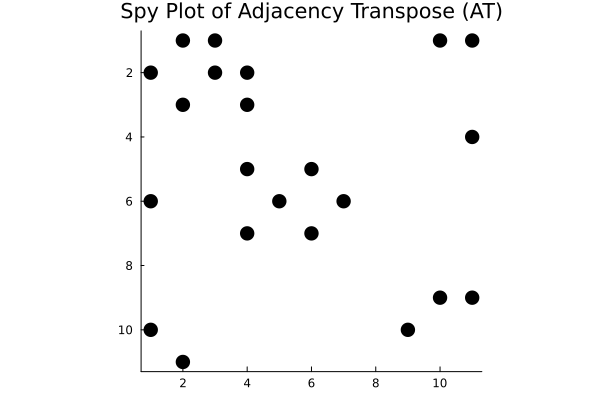

In [2]:
# COO-style lists for the graph's edges (from -> to)
# (These are the edges of graph 'g' from the previous notebook)
rows_i = [1,1,1,2,2,2,3,3,4,4,4,4,5,6,6,7,9,10,10,11,11,11]
cols_j = [2,10,6,3,1,11,1,2,5,3,2,7,6,7,5,6,10,1,9,1,4,9]

# To build AT, we pass (cols_j, rows_i) to the sparse constructor.
# This effectively swaps rows and columns, building the transpose directly.
AT = sparse(cols_j, rows_i, 1, 11, 11) 

# The spy plot shows the non-zero structure of AT.
# Reading down column 'j' shows all neighbors of vertex 'j'.
spy(AT, markersize=8, title="Spy Plot of Adjacency Transpose (AT)")

### Depth First Search (DFS) with Sparse Matrices

To illustrate how to use this adjacency matrix, we repeat the DFS algorithm.
The main operation is the loop over all neighbors of `ivertex`. We get this list by finding all non-zero entries in column `ivertex` of `AT`.

In [3]:
function sparse_dfs(AT, start)
    visited = falses(size(AT,1))
    
    function visit(ivertex)
        visited[ivertex] = true
        println("Visiting vertex #$ivertex")
        
        # Get the neighbor list!
        # findall(AT[:,ivertex] .!= 0) returns the row indices of all non-zeros
        # in column 'ivertex'. This is exactly the list of neighbors.
        for nb in findall(AT[:,ivertex] .!= 0)
            if !visited[nb]
                visit(nb)
            end
        end
    end
    
    visit(start)
    return nothing
end

sparse_dfs (generic function with 1 method)

In [4]:
# Run the DFS starting from vertex 1
sparse_dfs(AT, 1)

Visiting vertex #1
Visiting vertex #2
Visiting vertex #3
Visiting vertex #11
Visiting vertex #4
Visiting vertex #5
Visiting vertex #6
Visiting vertex #7
Visiting vertex #9
Visiting vertex #10


### Shortest Path (BFS) with Sparse Matrices

We can just as easily implement the Breadth First Search to find shortest paths. The logic is identical to the one we used for adjacency lists. The *only* change is how we get the list of neighbors for a vertex: instead of `g.vertices[ivertex].neighbors`, we use `findall(AT[:,ivertex] .!= 0)`.

In [5]:
function sparse_shortest_path_bfs(AT, start, finish)
    # 'parent[i]' stores the node we came from to get to 'i'.
    parent = zeros(Int64, size(AT, 1))
    
    S = [start] # Our queue
    parent[start] = start # Mark 'start' as visited (using itself as parent)
    
    while !isempty(S)
        ivertex = popfirst!(S) # Dequeue
        
        if ivertex == finish
            break # Found the destination, stop the search
        end
        
        # This is the key line, identical to the one in sparse_dfs
        for nb in findall(AT[:,ivertex] .!= 0)
            if parent[nb] == 0 # If neighbor 'nb' has not been visited
                parent[nb] = ivertex # Record the parent
                push!(S, nb)       # Enqueue the neighbor
            end
        end
    end
    
    # --- Path Reconstruction --- 
    path = Int64[]
    iv = finish # Start at the end
    while true
        pushfirst!(path, iv)
        if iv == start
            break # We're back at the start
        end
        iv = parent[iv] # Walk backward
    end
    return path
end

sparse_shortest_path_bfs (generic function with 1 method)

In [6]:
# Find the shortest path from 10 to 5
path = sparse_shortest_path_bfs(AT, 10, 5)
println("Shortest path from 10 to 5: $path")

Shortest path from 10 to 5: [10, 1, 6, 5]
